In [18]:
import pandas as pd

# Load the CSV file
df = pd.read_csv('data.csv')

# Filter the training split
test_df = df[df['Split'] == 'Test']
test_df

,Id,y,Split
11879,data/test/Benign/6602.jpg,0,Test
11880,data/test/Benign/6831.jpg,0,Test
11881,data/test/Benign/7005.jpg,0,Test
11882,data/test/Benign/7280.jpg,0,Test
11883,data/test/Benign/6683.jpg,0,Test
...,...,...,...
13874,data/test/Malignant/6543.jpg,1,Test
13875,data/test/Malignant/5738.jpg,1,Test
13876,data/test/Malignant/6165.jpg,1,Test
13877,data/test/Malignant/5927.jpg,1,Test


In [19]:
import cv2
from sklearn.cluster import KMeans
import numpy as np

def extract_colors(image_path, num_colors=10):
   
    image = cv2.imread(image_path)

    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
   
    pixels = image.reshape(-1, 3)
   
    kmeans = KMeans(n_clusters=num_colors)
    kmeans.fit(pixels)
  
    colors = kmeans.cluster_centers_
 
    counts = np.bincount(kmeans.labels_)
    return colors, counts

In [20]:
colors_list = []
counts_list = []

for image_path in train_df['Id']:
    colors, counts = extract_colors(image_path)
    colors_list.append(colors)
    counts_list.append(counts)


all_colors = np.vstack(colors_list)
all_counts = np.concatenate(counts_list)


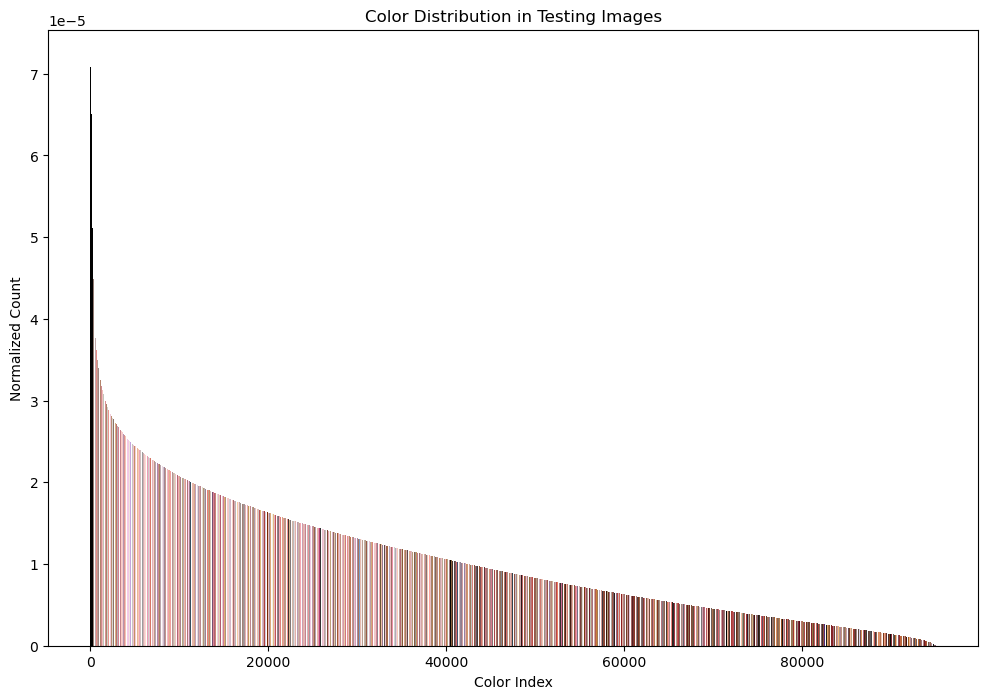

In [21]:
import matplotlib.pyplot as plt

normalized_counts = all_counts / np.sum(all_counts)


sorted_indices = np.argsort(normalized_counts)[::-1]
sorted_colors = all_colors[sorted_indices]
sorted_counts = normalized_counts[sorted_indices]


plt.figure(figsize=(12, 8))
plt.bar(range(len(sorted_colors)), sorted_counts, color=sorted_colors / 255)
plt.xlabel('Color Index')
plt.ylabel('Normalized Count')
plt.title('Color Distribution in Testing Images')
plt.show()


In [22]:
import pandas as pd

# Load the CSV file
df = pd.read_csv('data.csv')

# Filter the training split
train_df = df[df['Split'] == 'Train']
train_df

,Id,y,Split
0,data/train/Benign/206.jpg,0,Train
1,data/train/Malignant/3892.jpg,1,Train
2,data/train/Malignant/3890.jpg,1,Train
3,data/train/Benign/5904.jpg,0,Train
4,data/train/Benign/2955.jpg,0,Train
...,...,...,...
9498,data/train/Benign/3216.jpg,0,Train
9499,data/train/Benign/5013.jpg,0,Train
9500,data/train/Malignant/1165.jpg,1,Train
9501,data/train/Malignant/2596.jpg,1,Train


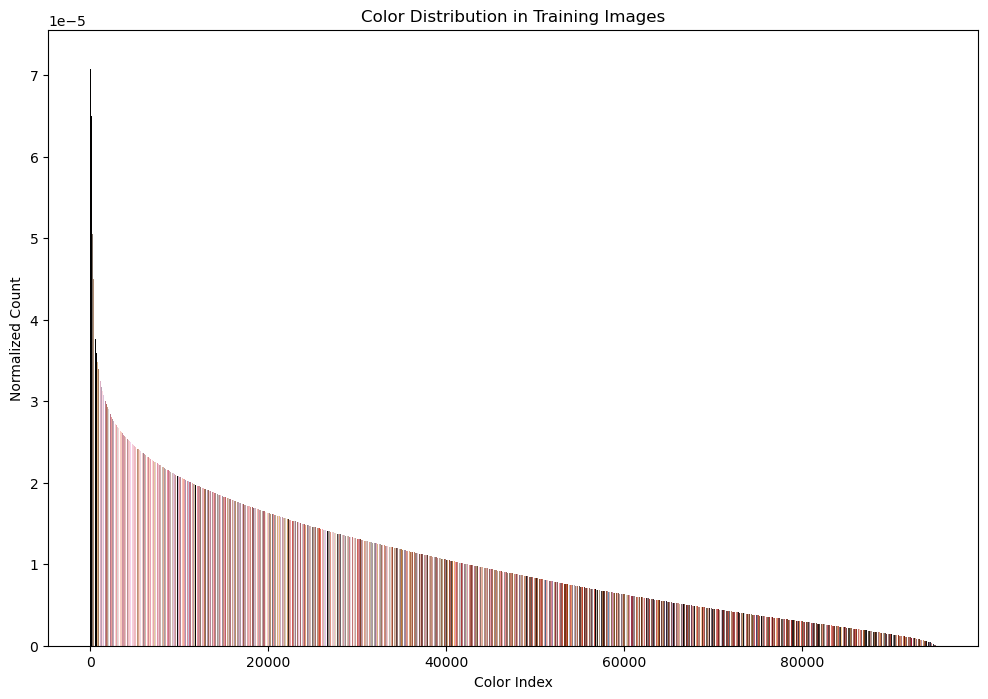

In [23]:
colors_list = []
counts_list = []

for image_path in train_df['Id']:
    colors, counts = extract_colors(image_path)
    colors_list.append(colors)
    counts_list.append(counts)


all_colors = np.vstack(colors_list)
all_counts = np.concatenate(counts_list)

import matplotlib.pyplot as plt

normalized_counts = all_counts / np.sum(all_counts)


sorted_indices = np.argsort(normalized_counts)[::-1]
sorted_colors = all_colors[sorted_indices]
sorted_counts = normalized_counts[sorted_indices]


plt.figure(figsize=(12, 8))
plt.bar(range(len(sorted_colors)), sorted_counts, color=sorted_colors / 255)
plt.xlabel('Color Index')
plt.ylabel('Normalized Count')
plt.title('Color Distribution in Training Images')
plt.show()


Loaded pretrained weights for densenet121


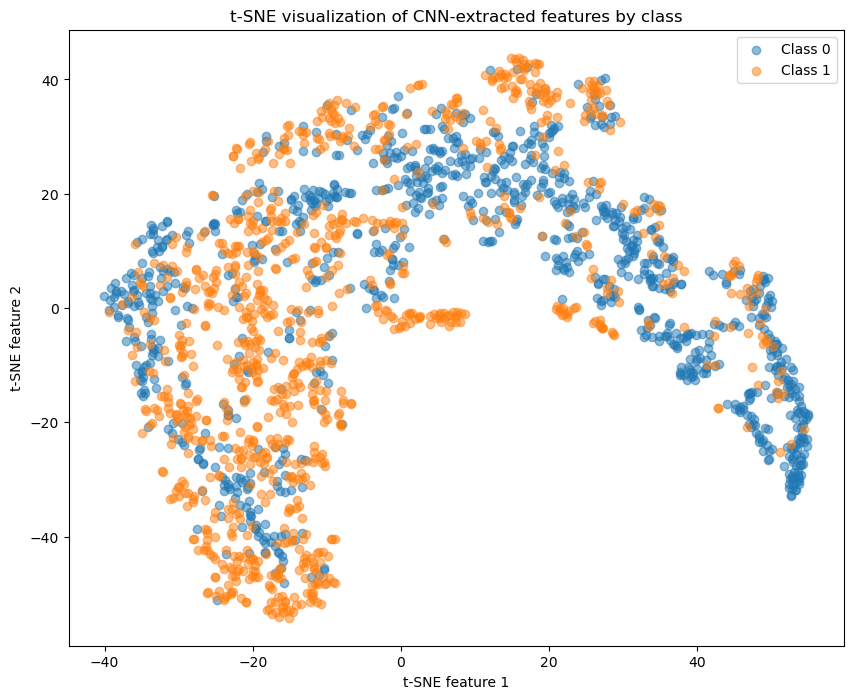

In [14]:
import torch
from torchvision import models, transforms
from torch.nn import functional as F
from PIL import Image
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns
from densenet_pytorch import DenseNet

class DenseNet_(torch.nn.Module):
    def __init__(self, num_classes=2, pretrained=True):
        super(DenseNet_, self).__init__()
        self.model = DenseNet.from_pretrained('densenet121')
        in_features = self.model.classifier.in_features
        self.model.classifier = torch.nn.Linear(in_features, num_classes)
    
    def forward(self, x):
        out= self.model.features(x)      
        out = F.adaptive_avg_pool2d(out, (1, 1)).view(out.size(0), -1)     
        return out



model = DenseNet_()
experiment_dir = "/home/cloudcorn/sameerah/my_exam/detect-malignant/experiments/exp3"
model.load_state_dict(torch.load(experiment_dir + "/best_acc.pth"))
model.eval()


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)


transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])


def extract_features(image_path, model, transform, device):
    image = Image.open(image_path).convert('RGB')
    image = transform(image).unsqueeze(0).to(device)
    with torch.no_grad():
        features = model(image)
    return features.squeeze().cpu().numpy()


df = pd.read_csv('data.csv')  
test_df = df[df['Split']=='Test'] 

features_list = []
labels = []


for idx, row in test_df.iterrows():
    features = extract_features(row['Id'], model, transform, device) 
    features_list.append(features)
    labels.append(row['y'])  

features_array = np.array(features_list)
labels = np.array(labels)


pca = PCA(n_components=50) 
pca_features = pca.fit_transform(features_array)


tsne = TSNE(n_components=2, random_state=42)
tsne_features = tsne.fit_transform(pca_features)


plt.figure(figsize=(10, 8))
for class_label in np.unique(labels):
    indices = np.where(labels == class_label)
    plt.scatter(tsne_features[indices, 0], tsne_features[indices, 1], label=f'Class {class_label}', alpha=0.5)
plt.xlabel('t-SNE feature 1')
plt.ylabel('t-SNE feature 2')
plt.title('t-SNE visualization of CNN-extracted features by class')
plt.legend()
plt.show()




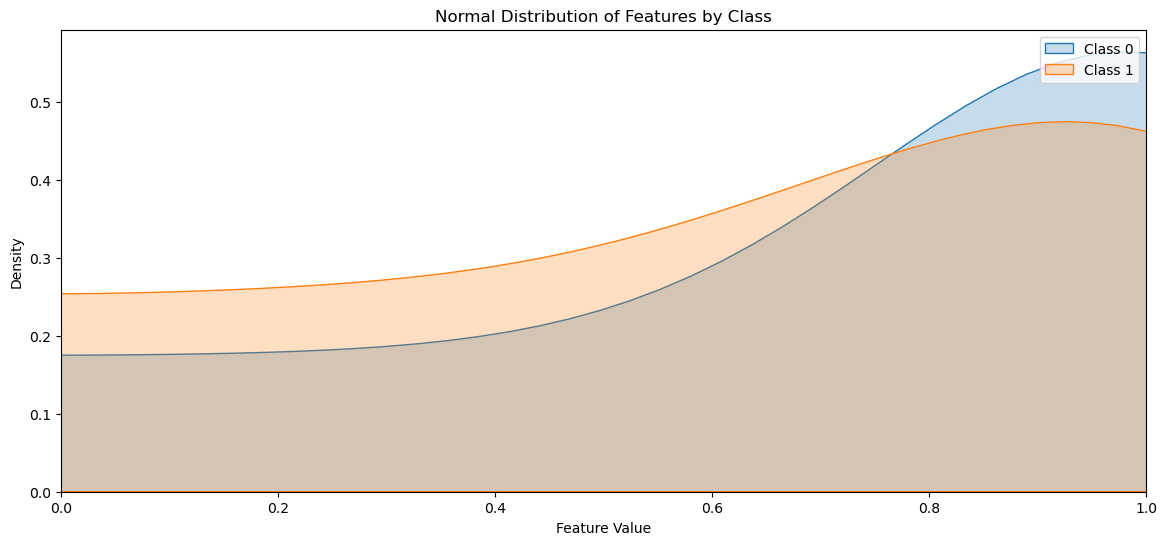

In [10]:
plt.figure(figsize=(14, 6))
for class_label in np.unique(labels):
    indices = np.where(labels == class_label)
    class_features = features_array[indices].flatten()
    sns.kdeplot(class_features, label=f'Class {class_label}', fill=True)
plt.xlabel('Feature Value')
plt.ylabel('Density')
plt.title('Normal Distribution of Features by Class')
plt.legend()
plt.xlim(0, 1) 
plt.show()

Loaded pretrained weights for densenet121


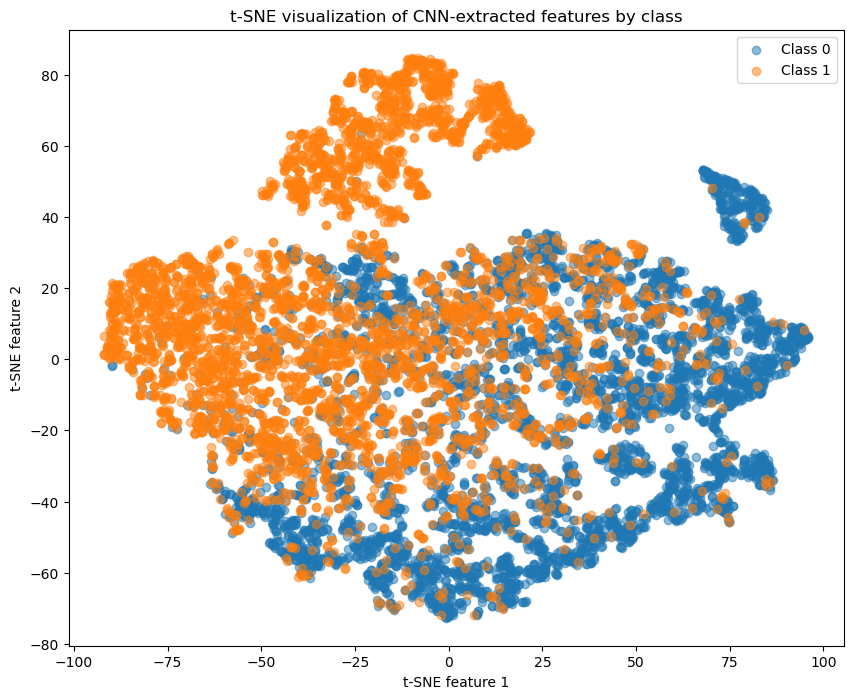

In [17]:
import torch
from torchvision import models, transforms
from torch.nn import functional as F
from PIL import Image
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns
from densenet_pytorch import DenseNet 

class DenseNet_(torch.nn.Module):
    def __init__(self, num_classes=2, pretrained=True):
        super(DenseNet_, self).__init__()
        self.model = DenseNet.from_pretrained('densenet121')
        in_features = self.model.classifier.in_features
        self.model.classifier = torch.nn.Linear(in_features, num_classes)
    
    def forward(self, x):
        out= self.model.features(x)  
        out = F.adaptive_avg_pool2d(out, (1, 1)).view(out.size(0), -1)
#         out = out.reshape(1,1024*7*7)     
        return out



model = DenseNet_()
experiment_dir = "/home/cloudcorn/sameerah/my_exam/detect-malignant/experiments/exp3"
model.load_state_dict(torch.load(experiment_dir + "/best_f1.pth"))
model.eval()


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)


transform = transforms.Compose([
                          
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
    
])


def extract_features(image_path, model, transform, device):
    image = Image.open(image_path).convert('RGB')
    image = transform(image).unsqueeze(0).to(device)
    with torch.no_grad():
        features = model(image)
    return features.squeeze().cpu().numpy()


df = pd.read_csv('data.csv')  
train_df = df[df['Split']=='Train']
features_list = []
labels = []


for idx, row in train_df.iterrows():
    features = extract_features(row['Id'], model, transform, device) 
    features_list.append(features)
    labels.append(row['y'])  

features_array = np.array(features_list)
labels = np.array(labels)


pca = PCA(n_components=50) 
pca_features = pca.fit_transform(features_array)


tsne = TSNE(n_components=2, random_state=42)
tsne_features = tsne.fit_transform(pca_features)


plt.figure(figsize=(10, 8))
for class_label in np.unique(labels):
    indices = np.where(labels == class_label)
    plt.scatter(tsne_features[indices, 0], tsne_features[indices, 1], label=f'Class {class_label}', alpha=0.5)
plt.xlabel('t-SNE feature 1')
plt.ylabel('t-SNE feature 2')
plt.title('t-SNE visualization of CNN-extracted features by class')
plt.legend()
plt.show()

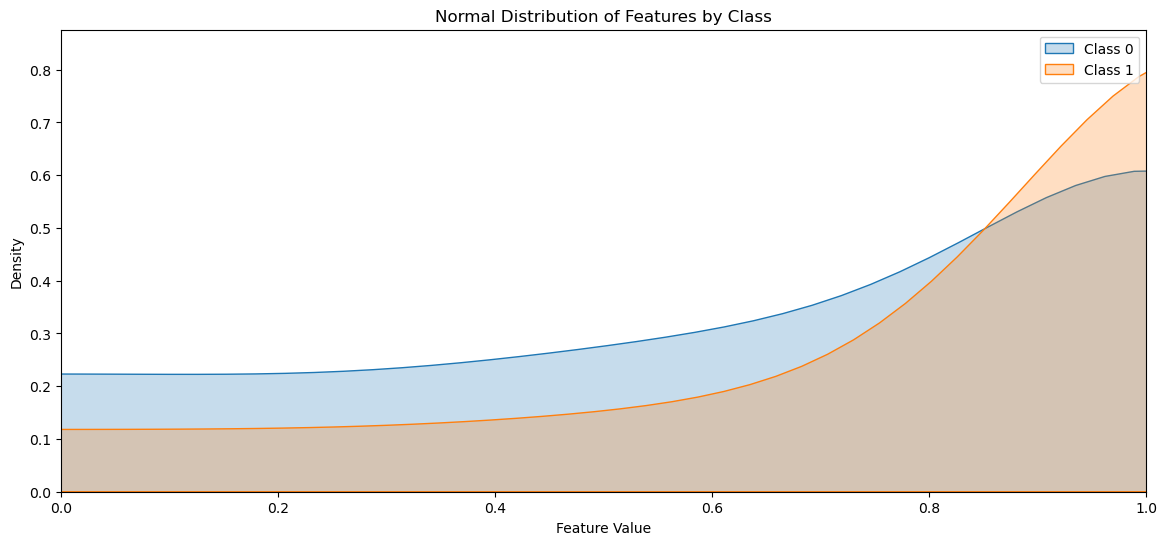

In [8]:
plt.figure(figsize=(14, 6))
for class_label in np.unique(labels):
    indices = np.where(labels == class_label)
    class_features = features_array[indices].flatten()
    sns.kdeplot(class_features, label=f'Class {class_label}', fill=True)
plt.xlabel('Feature Value')
plt.ylabel('Density')
plt.title('Normal Distribution of Features by Class')
plt.legend()
plt.xlim(0, 1) 
plt.show()